# Overview

We have a couple of folders with cellenONE images. We will convert these into cropped images with metadata and load them into LanceDB

In [1]:
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
import lance

from CellVision.data.preprocessing.raw2crop import mask_cells, crop_cells, pad_borders
from CellVision.data.preprocessing.utils import merge_backgrounds
from CellVision.data.preprocessing.metrics import contour_metrics

%matplotlib inline

# 1. Raw image -> Cell

### I. Get paths of the raw data

In [2]:
root_img = '/public/conode53/sam/SCI/cellenONE/cellenONE_Reports'
root_data_storage = '/home/sam/SCI/cellenONE_project/datasets'

paths_img = {
    path_1.split('/')[-1]: {
        path_2.split('/')[-1].split('_')[0]: [
            p for p in list(glob(os.path.join(path_2, '*'))) if ('_OV_' not in p) and ('Background' not in p) and (p.endswith('.png'))
        ] for path_2 in glob(os.path.join(path_1, '*'))
    } for path_1 in glob(os.path.join(root_img, '*'))
}

In [3]:
count_df = []

for lab, runs in paths_img.items():
    for run, paths in runs.items():
        count_df.append(
            [lab, run, len(paths)]
        )
count_df = pd.DataFrame(count_df).rename(columns={
    0: 'lab',
    1: 'run',
    2: 'count'
}).sort_values(['lab', 'run']).reset_index(drop=True)

In [4]:
count_df

,lab,run,count
0,Plate_01_Backup,HEK,120
1,Plate_01_Backup,K562,96
2,Plate_01_Backup,NEG,24
3,Plate_02_BOGDAN_,HEK,108
4,Plate_02_BOGDAN_,K562,108
5,Plate_02_BOGDAN_,NEG,24
6,Plate_03_BOGDAN_,HEK,108
7,Plate_03_BOGDAN_,K562,108
8,Plate_03_BOGDAN_,NEG,24
9,Plate_04_BOGDAN,HEK,108


### II. Get masks and crops

In [5]:
samples = []

for lab, runs in tqdm(paths_img.items(), desc='Iterating over labs'):
    for cell_type, paths in runs.items():
        # Create background by averaging over all pictures
        # Idea is that it is very unlikely that in majority of pictures
        # a cell is present at the same position.
        bg = merge_backgrounds(*paths)
        sample_type = run.split('_')[0]

        for path in paths:
            filename = path.split('/')[-1]

            cell, diff, mask = mask_cells(
                path_cell=path,
                path_background=bg,
                visualize=False
            )
            cropped_cells, _ = crop_cells(
                img_cell=cell,
                mask=mask,
                visualize=False
            )
            cropped_cells_diff, contours = crop_cells(
                img_cell=diff,
                mask=mask,
                visualize=False
            )

            if len(cropped_cells_diff) != 0:
                crops = {
                    'cell': cropped_cells,
                    'cell_diff': cropped_cells_diff,
                    'mask': [mask]*len(cropped_cells),
                    'contours': contours,
                    'plate': [lab]*len(cropped_cells),
                    'sample_type': [cell_type]*len(cropped_cells),
                    'ImageFile': [filename]*len(cropped_cells),
                    'path': [path]*len(cropped_cells)
                }
            else:
                crops = {
                    'cell': [np.nan],
                    'cell_diff': [np.nan],
                    'mask': [mask],
                    'contours': contours,
                    'plate': [lab],
                    'sample_type': [cell_type],
                    'ImageFile': [filename],
                    'path': [path]
                }
        
            samples.append(crops)

Iterating over labs: 100%|██████████| 14/14 [00:45<00:00,  3.24s/it]


### II. Add metrics

In [6]:
df = pd.DataFrame(
    samples
)
collapsed = df.apply(lambda row: pd.DataFrame(row.tolist()).T, axis=1)
collapsed = pd.concat(collapsed.tolist(), ignore_index=True)
collapsed = collapsed.rename(
    columns={
        0: 'cell',
        1: 'cell_diff',
        2: 'mask',
        3: 'contours',
        4: 'plate',
        5: 'sample_type',
        6: 'ImageFile',
        7: 'path'
    }
)
n_cells = collapsed.groupby('path').count()['cell']
df = collapsed.merge(n_cells.reset_index(name='n'), on = 'path')

metrics = pd.DataFrame(df['contours'].apply(lambda c: contour_metrics(c)).tolist())

metrics_2 = pd.DataFrame(df['contours'].apply(lambda c: cv2.boundingRect(c)).tolist()).rename(
    columns={
        0: 'x',
        1: 'y',
        2: 'width',
        3: 'height'
    }
)

df = pd.concat([df, metrics, metrics_2], axis=1)

In [7]:
print(df.columns)

df.head(3)[
    ['plate', 'sample_type', 'area', 'perimeter', 'circularity',
       'equivalent_diameter', 'aspect_ratio', 'elongation', 'solidity',
       'convexity', 'extent', 'x', 'y', 'width', 'height']
]

Index(['cell', 'cell_diff', 'mask', 'contours', 'plate', 'sample_type',
       'ImageFile', 'path', 'n', 'area', 'perimeter', 'circularity',
       'equivalent_diameter', 'aspect_ratio', 'elongation', 'solidity',
       'convexity', 'extent', 'x', 'y', 'width', 'height'],
      dtype='object')


,plate,sample_type,area,perimeter,circularity,equivalent_diameter,aspect_ratio,elongation,solidity,convexity,extent,x,y,width,height
0,Plate_13_CHRISTINE,K562,1105.5,127.012192,0.861148,37.517547,1.176471,0.886891,0.977886,0.971623,0.812868,305,77,40,34
1,Plate_13_CHRISTINE,K562,541.0,92.627416,0.792370,26.245430,0.709677,0.801794,0.980961,0.989650,0.793255,731,44,22,31
2,Plate_13_CHRISTINE,K562,1061.5,124.669047,0.858248,36.763348,1.242424,0.797483,0.981507,0.964124,0.784553,97,80,41,33


# 2. Add metadata

In general, the boundary of the injection zone is at pixel 340 and the boundary to the sedimentation zone at pixel 540.

TODO: Extract these boundaries from the OV-images.

--> Zones are defined in the isolated.xls ('EjBound', 'SedBound')

In [8]:
def get_zone(x, boundary_1=340, boundary_2=540):
    if x<340:
        return 1
    elif x<540:
        return 2
    return 3

df['zone'] = df['x'].apply(lambda x: get_zone(x))
df['x_order'] = df.groupby('path')['x'].rank(method='first').astype(int)

Get the paths to the isolated.xls files (metadata cellenONE)

In [9]:
metadata_cellenone = []
for path in glob(os.path.join(
    root_img, '*', '*', 'Reordered_*_isolated.xls'
)):
    cellenone_df = pd.read_csv(path, sep='\t').dropna(axis=1)
    # cellenone_df['plate'] = path.split('/')[-3]
    # cellenone_df['sample_type'] = path.split('/')[-2].split('_')[0]
    
    cellenone_df = cellenone_df.rename(columns={c: c.strip() for c in cellenone_df.columns})

    if 'ImageFile' in cellenone_df.columns:
        cellenone_df['ImageFile'] = cellenone_df['ImageFile'].apply(lambda x: x.split('"')[1] if '"' in x else None)
    
    metadata_cellenone.append(cellenone_df)

metadata_cellenone = pd.concat(metadata_cellenone, ignore_index=True)
metadata_cellenone = metadata_cellenone.dropna(subset='ImageFile').reset_index(drop=True)
metadata_cellenone.shape

(3191, 31)

In [10]:
df = df.merge(
    metadata_cellenone,
    on='ImageFile',
    how='left'
)

In [11]:
df.columns

Index(['cell', 'cell_diff', 'mask', 'contours', 'plate', 'sample_type',
       'ImageFile', 'path', 'n', 'area', 'perimeter', 'circularity',
       'equivalent_diameter', 'aspect_ratio', 'elongation', 'solidity',
       'convexity', 'extent', 'x', 'y', 'width', 'height', 'zone', 'x_order',
       'DropNo', 'X', 'Y', 'Diameter', 'Elongation', 'Circularity',
       'Intensity', 'Teg', 'Plate', 'Well', 'Target', 'Field', 'XPos', 'YPos',
       'Date', 'Time', 'Background', 'EjBound', 'SedBound', 'DetDiaMinTrans',
       'DetDiaMaxTrans', 'IsoDiaMinTrans', 'IsoDiaMaxTrans', 'IsoIntMinTrans',
       'IsoIntMaxTrans', 'IsoDiaMinFlu', 'IsoDiaMaxFlu', 'IsoIntMinFlu',
       'IsoIntMaxFlu', 'PlatePosition'],
      dtype='object')

# 3. Exploration of the data

### I. Gathering some statistics

Number of cells per image and per lab

/tmp/ipykernel_3194141/73838928.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(len)


<Axes: xlabel='count', ylabel='plate'>

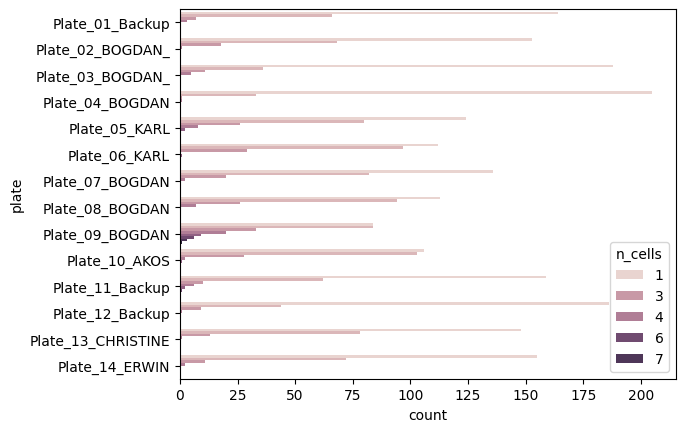

In [12]:
n_count_df = (
    df
        .groupby(['plate', 'ImageFile'])
        .apply(len)
        .reset_index()
        .rename(columns={0: 'n_cells'})
        .groupby(['plate'])['n_cells']
        .value_counts()
        .reset_index()
)

sns.barplot(
    n_count_df,
    x='count',
    y='plate',
    hue='n_cells'
)

Image shapes

<Axes: xlabel='height', ylabel='plate'>

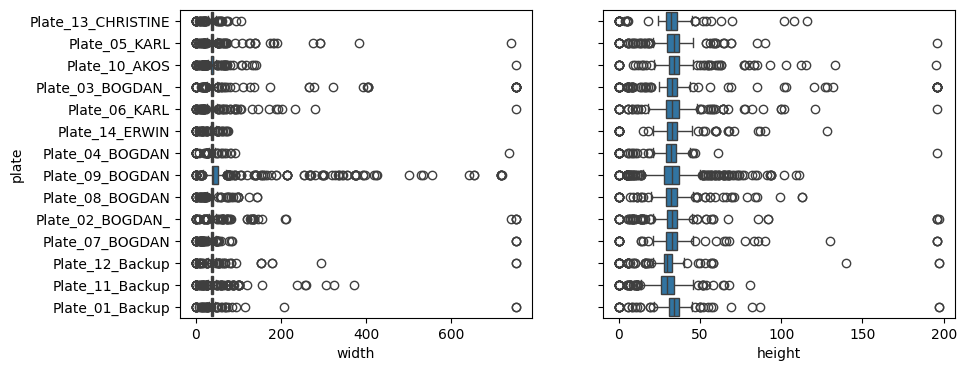

In [13]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))

sns.boxplot(
    df,
    x='width',
    y='plate',
    ax=ax[0]
)

sns.boxplot(
    df,
    x='height',
    y='plate',
    ax=ax[1]
)

<Axes: xlabel='height', ylabel='plate'>

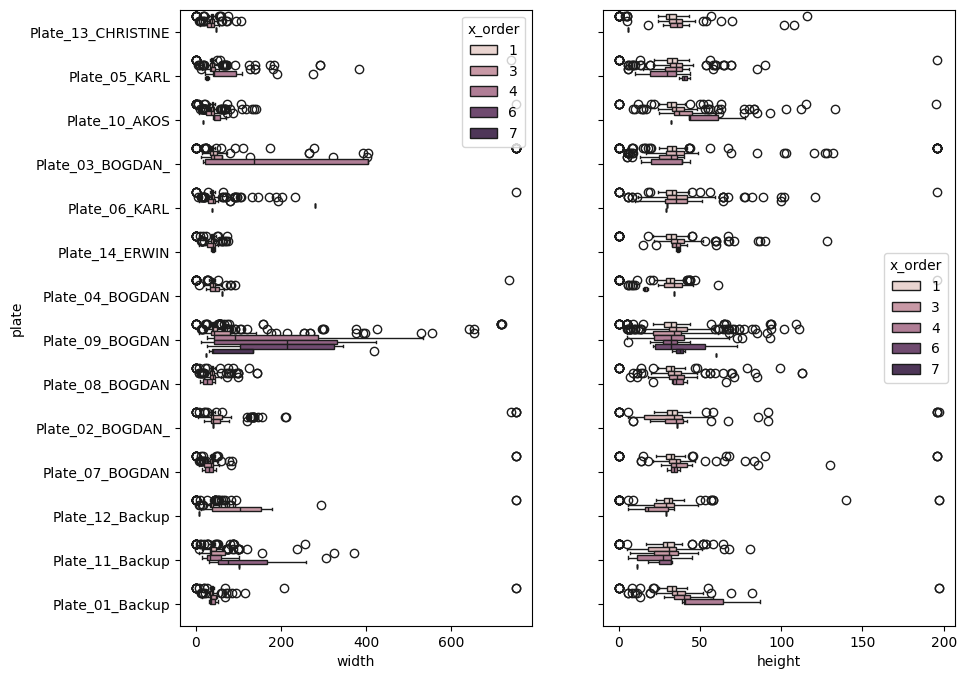

In [14]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,8))

sns.boxplot(
    df,
    x='width',
    y='plate',
    hue='x_order',
    ax=ax[0]
)

sns.boxplot(
    df,
    x='height',
    y='plate',
    hue='x_order',
    ax=ax[1]
)

### II. Identifying features indicating outliers and failed segmentations

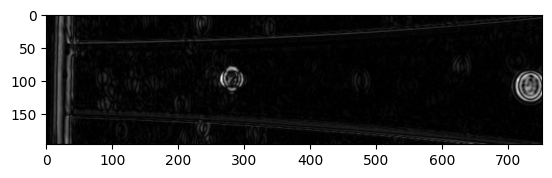

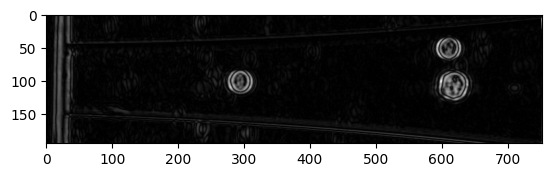

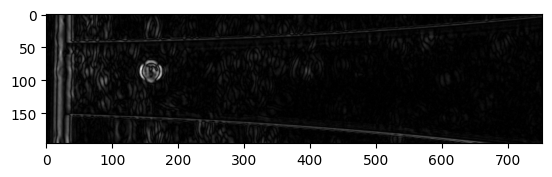

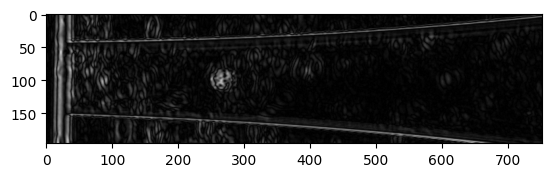

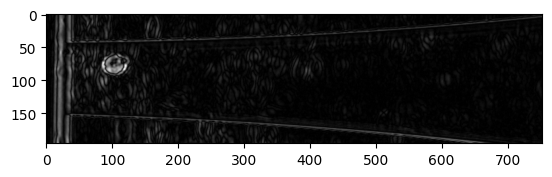

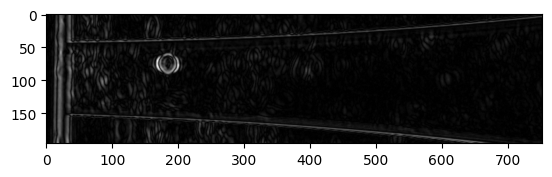

In [15]:
n = 0
for i, row in df[df['height']>150].iterrows():
    
    plt.imshow(row['cell_diff'], cmap='grey')
    plt.show()
    
    n += 1
    if n > 5:
        break


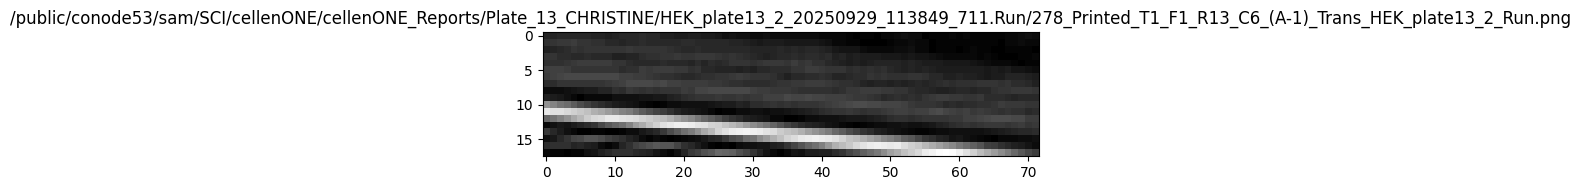

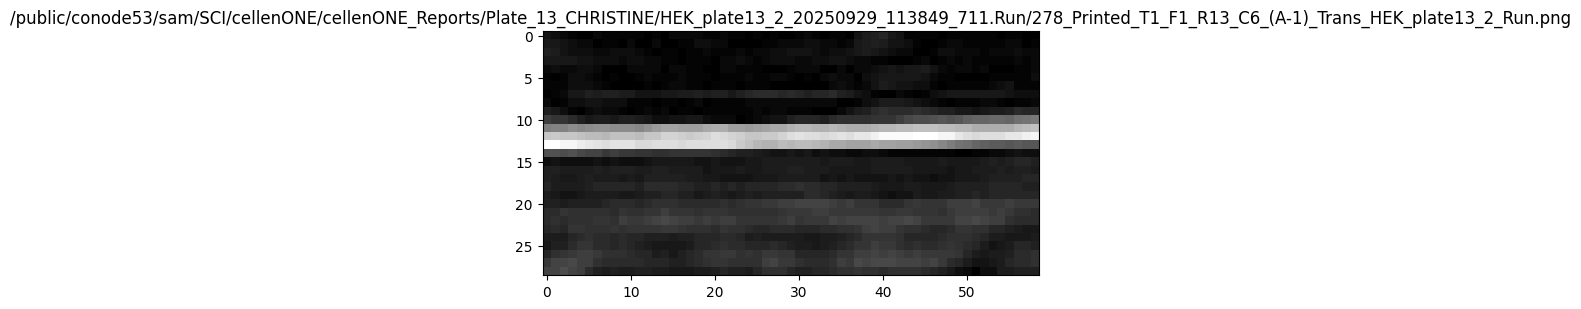

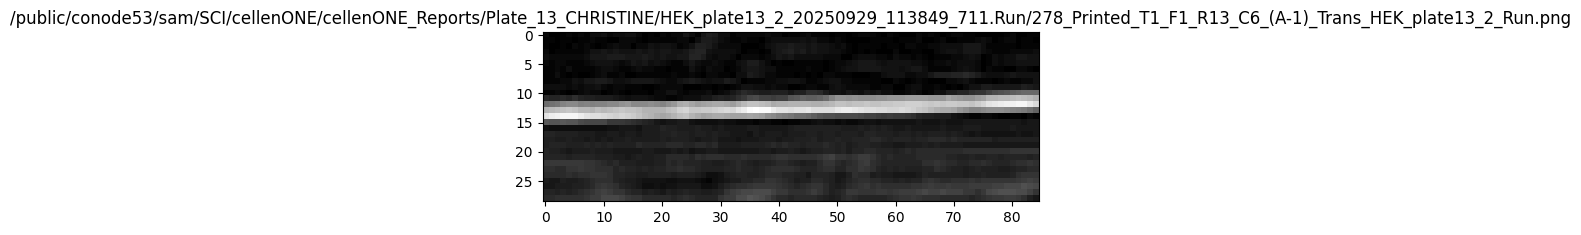

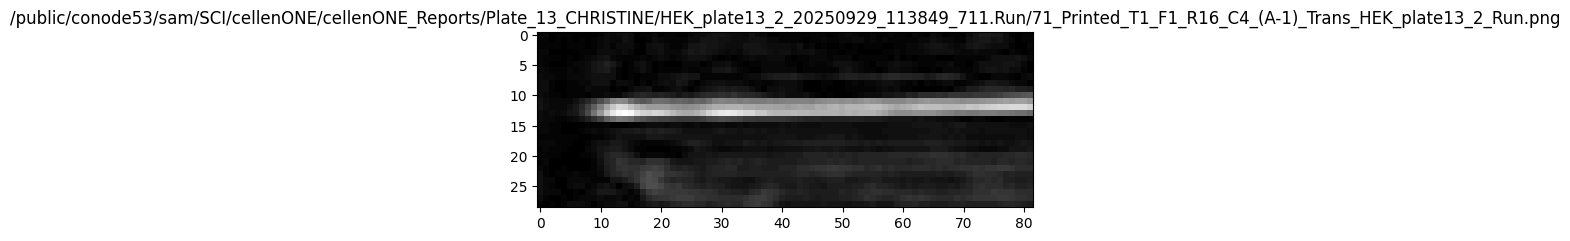

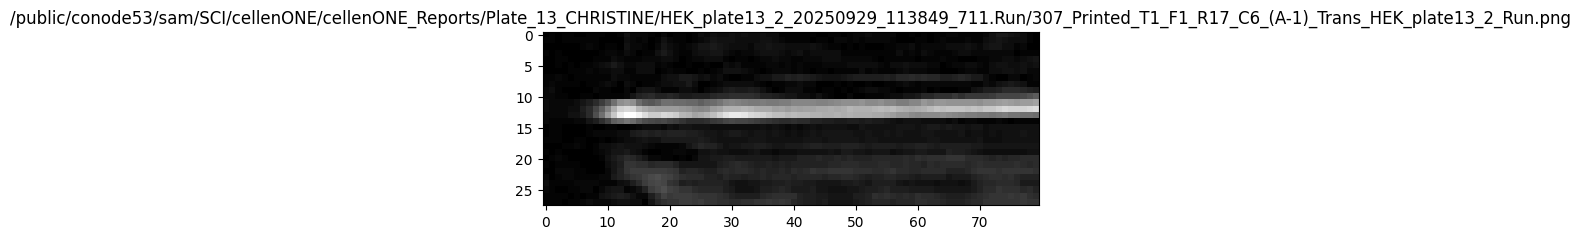

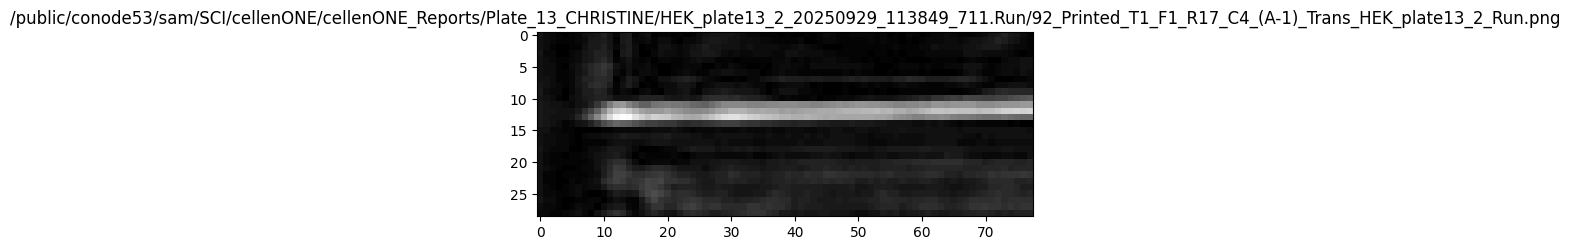

In [16]:
n = 0
for i, row in df[df['height']<15].iterrows():
    
    plt.imshow(row['cell_diff'], cmap='grey')
    plt.title(row['path'])
    plt.show()
    
    n += 1
    if n > 5:
        break


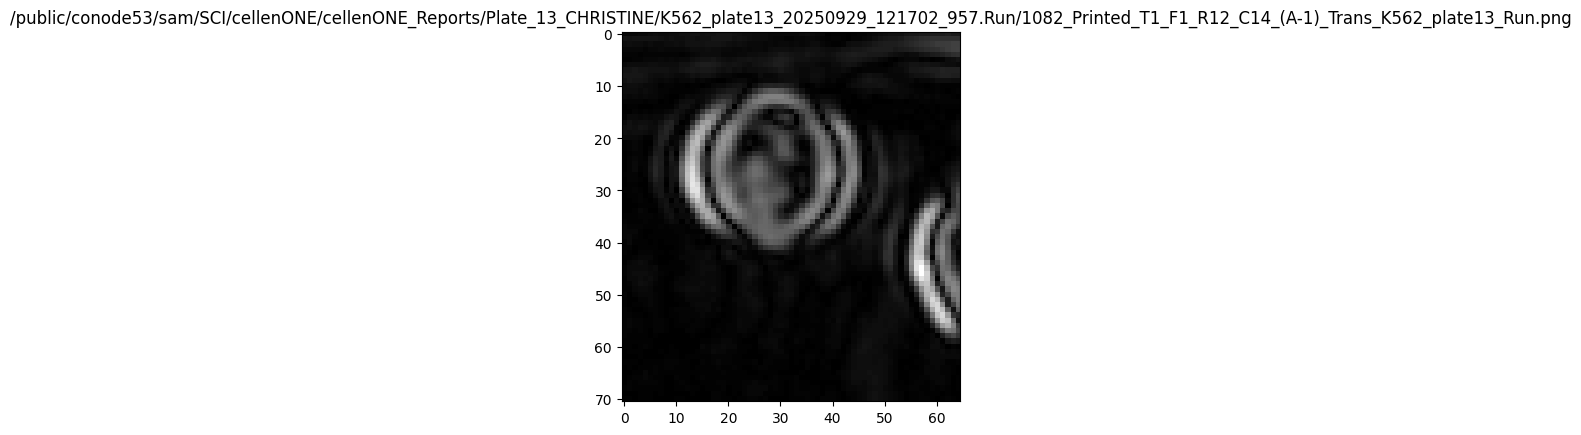

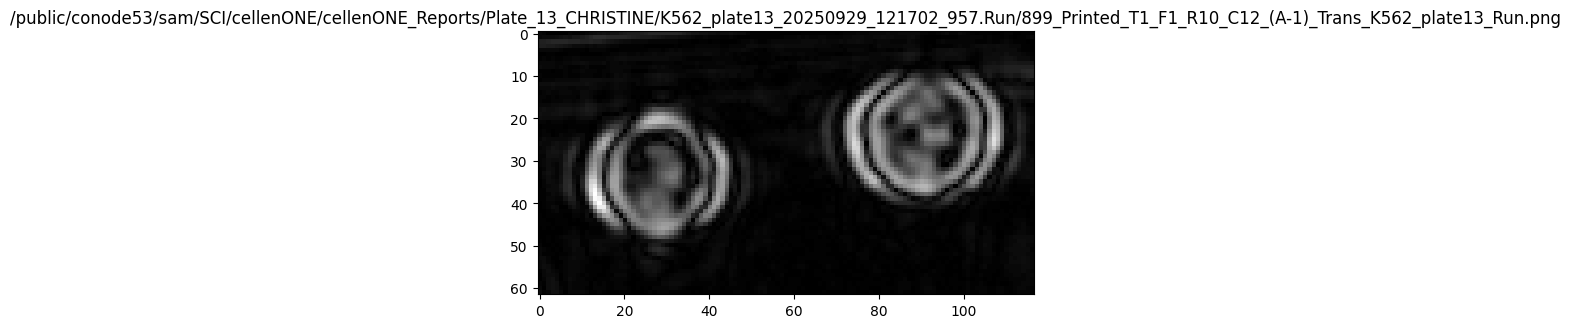

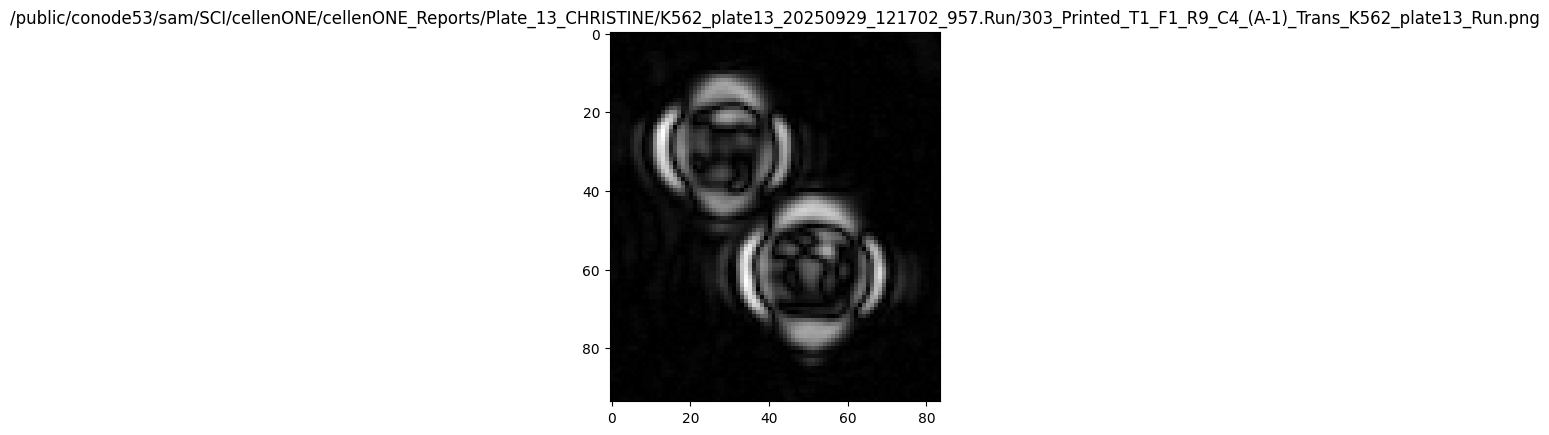

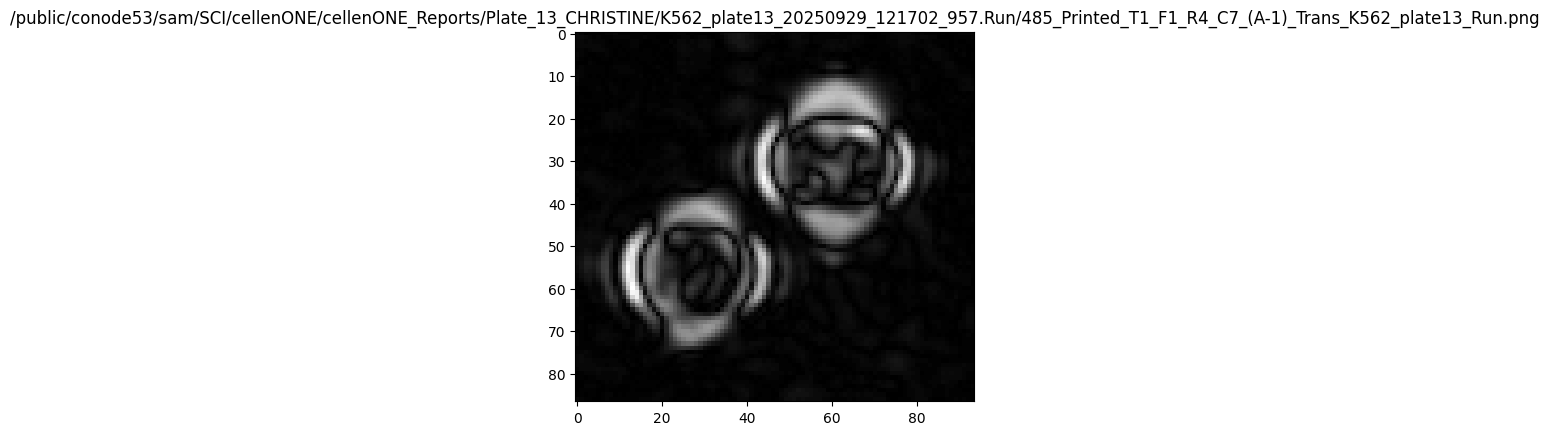

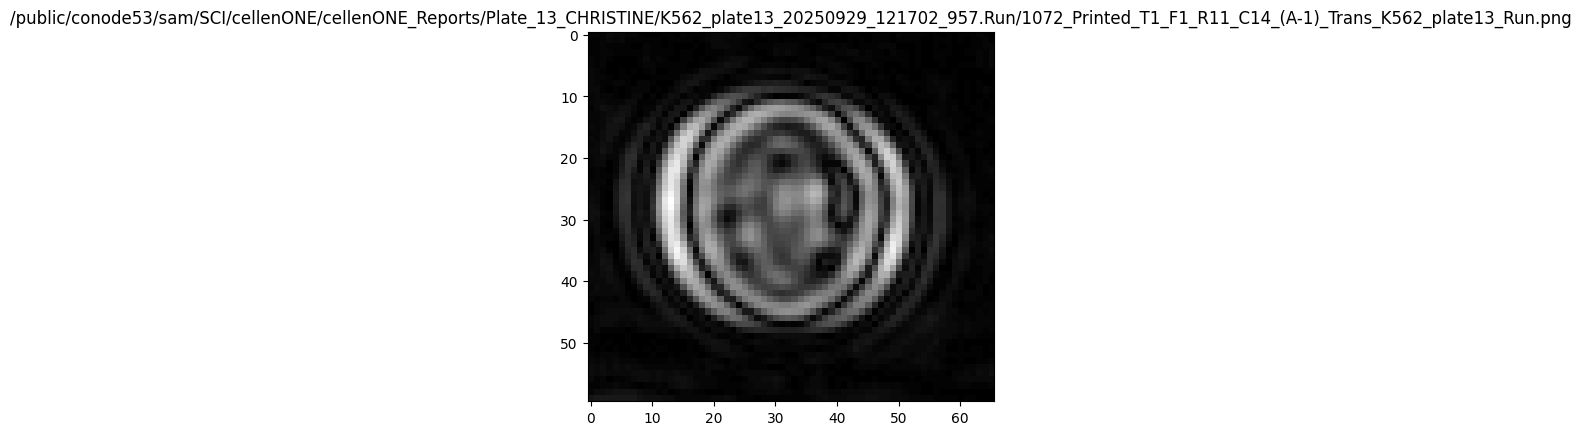

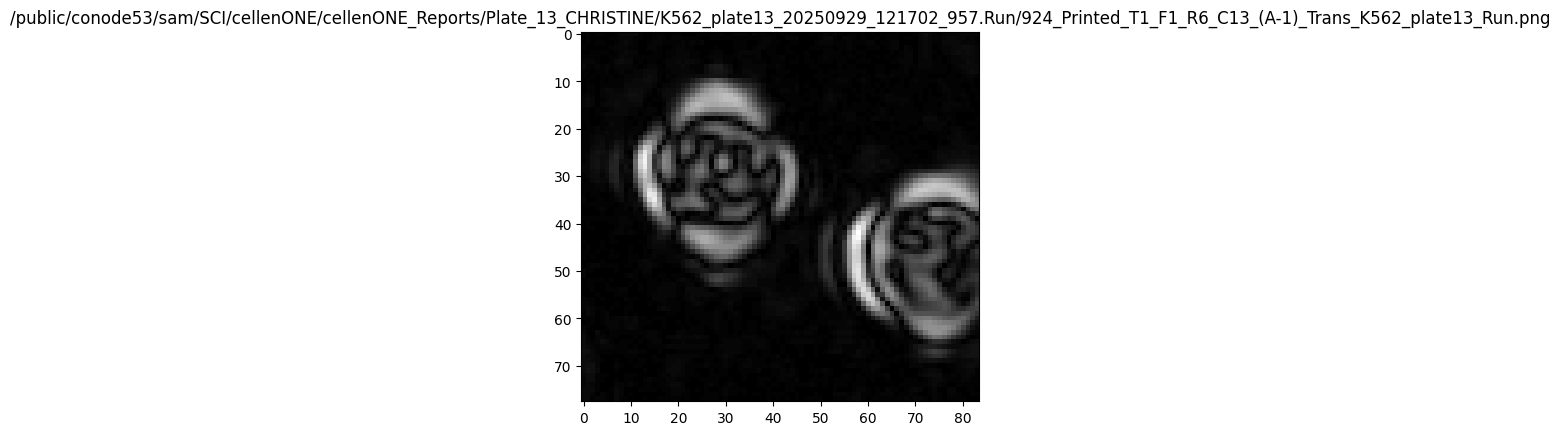

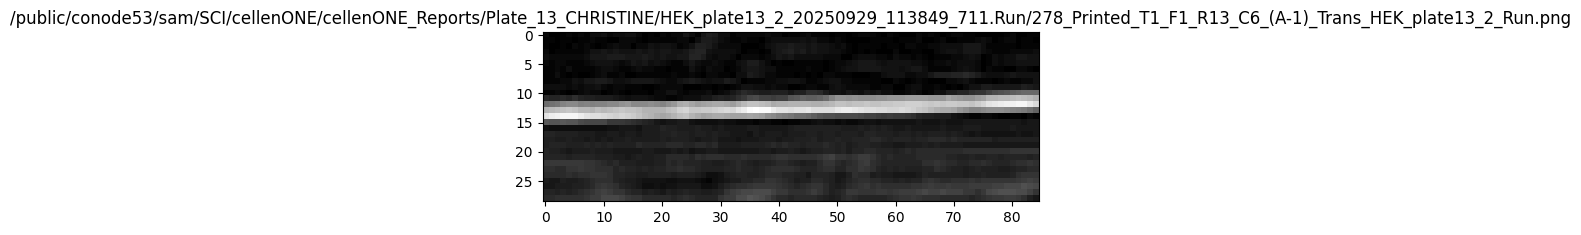

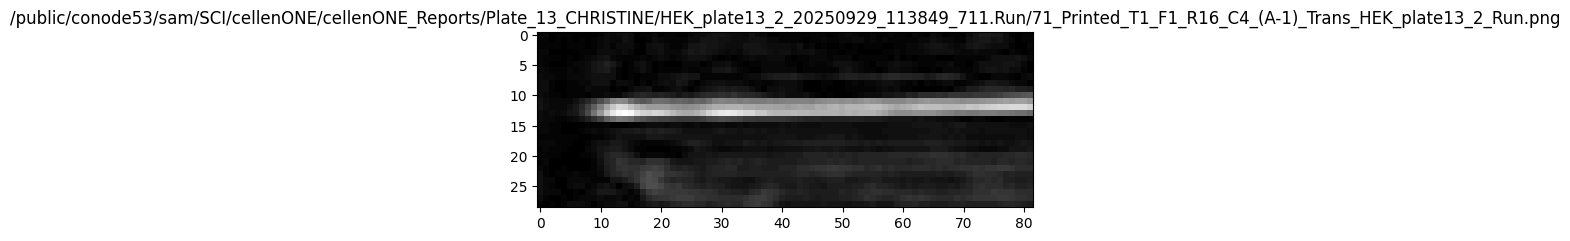

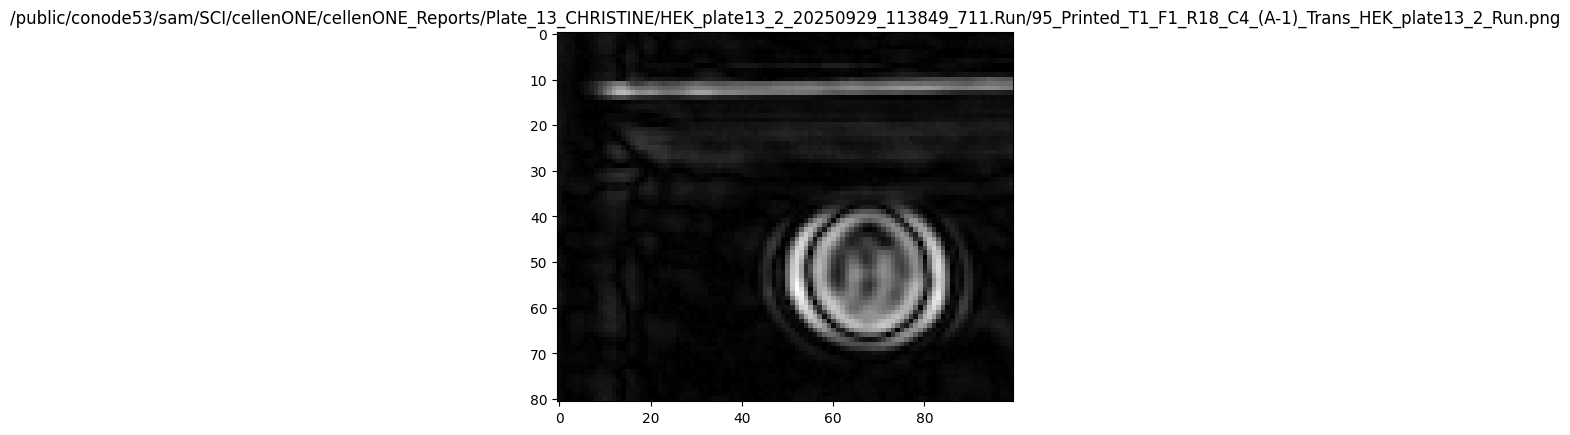

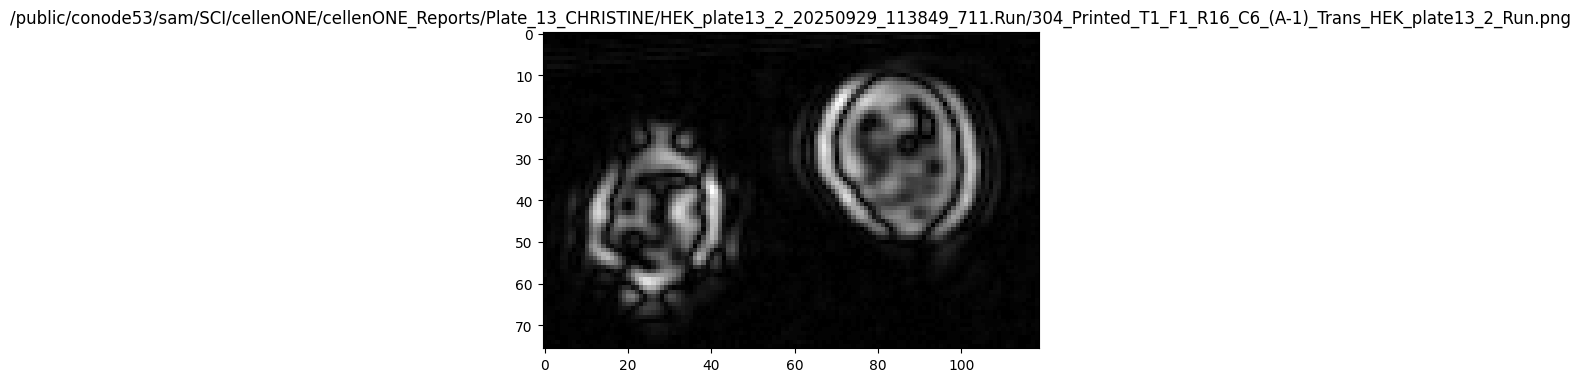

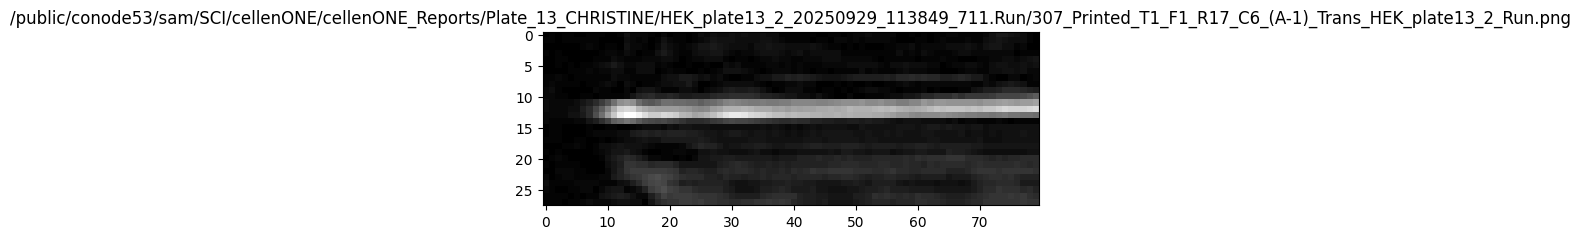

In [17]:
n = 0
for i, row in df[df['width']>50].iterrows():
    
    plt.imshow(row['cell_diff'], cmap='grey')
    plt.title(row['path'])
    plt.show()
    
    n += 1
    if n > 10:
        break


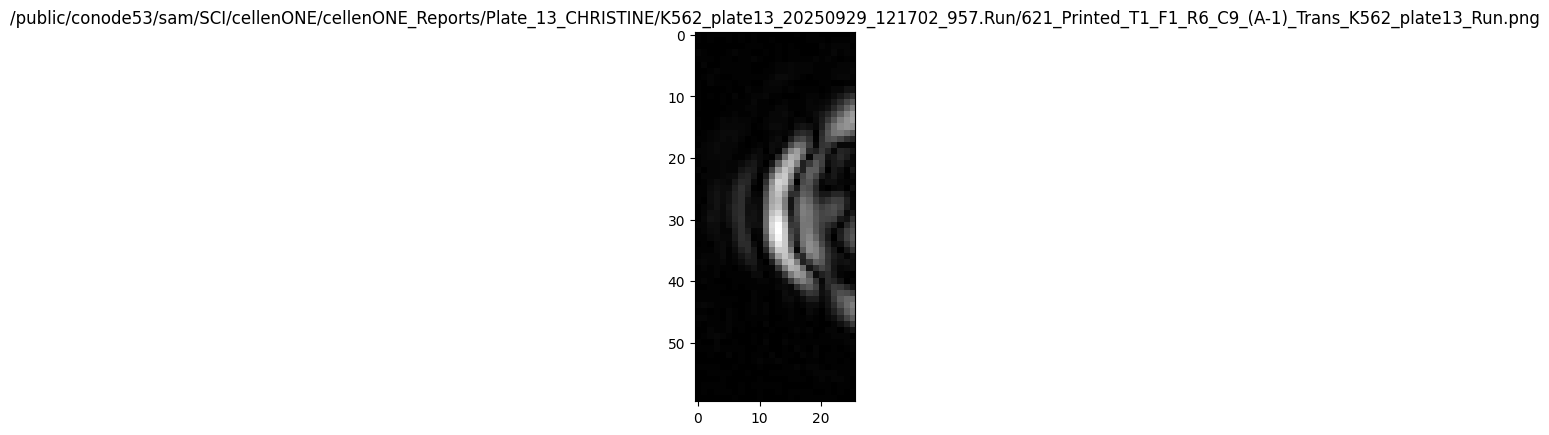

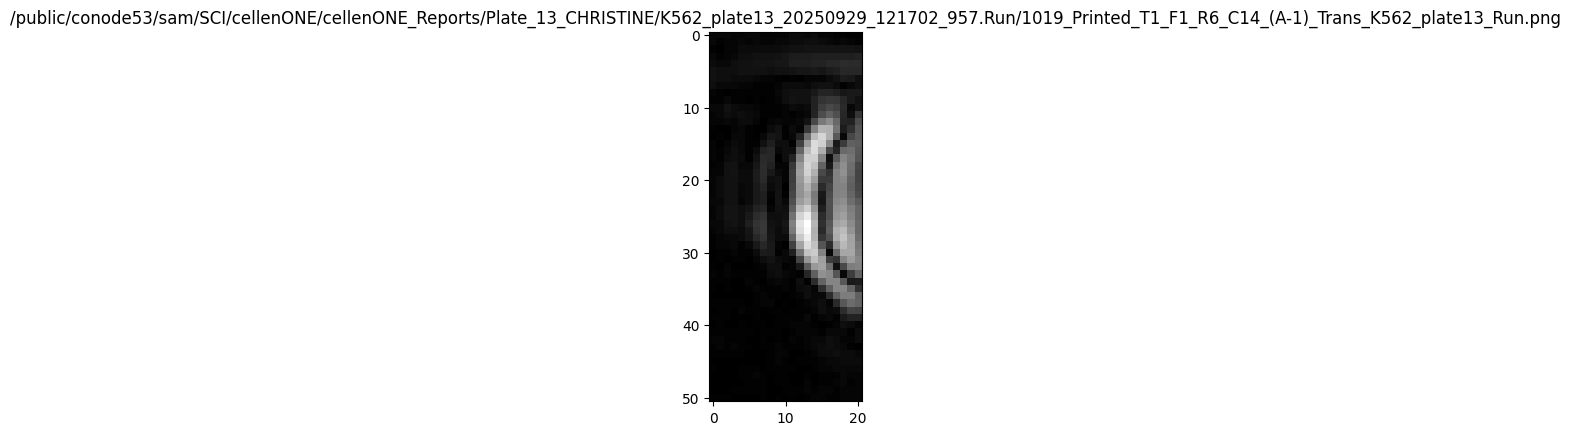

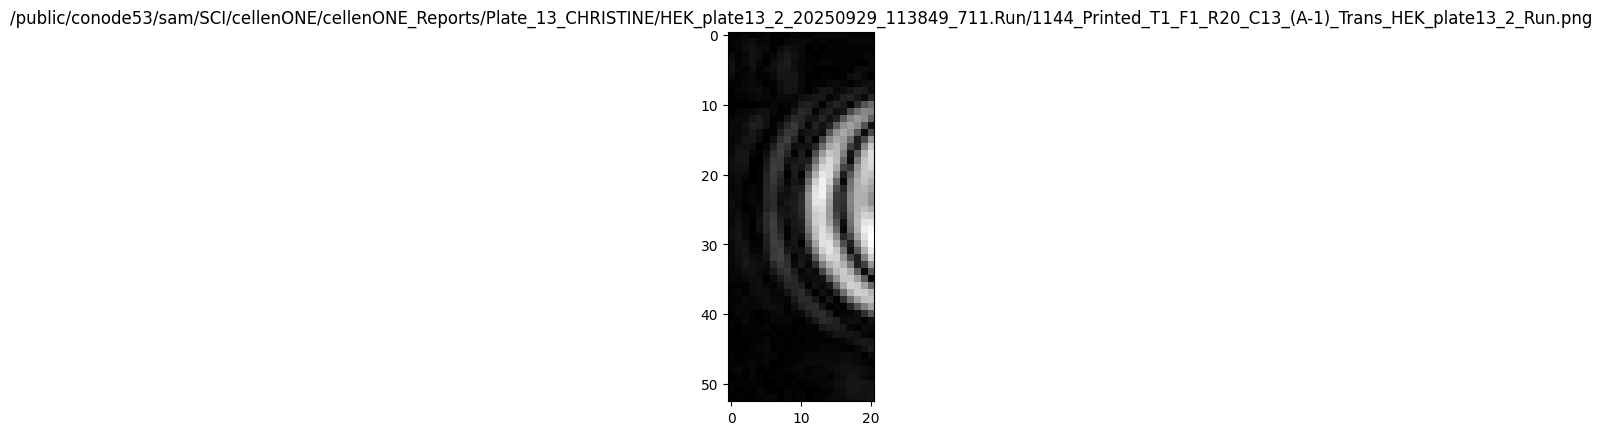

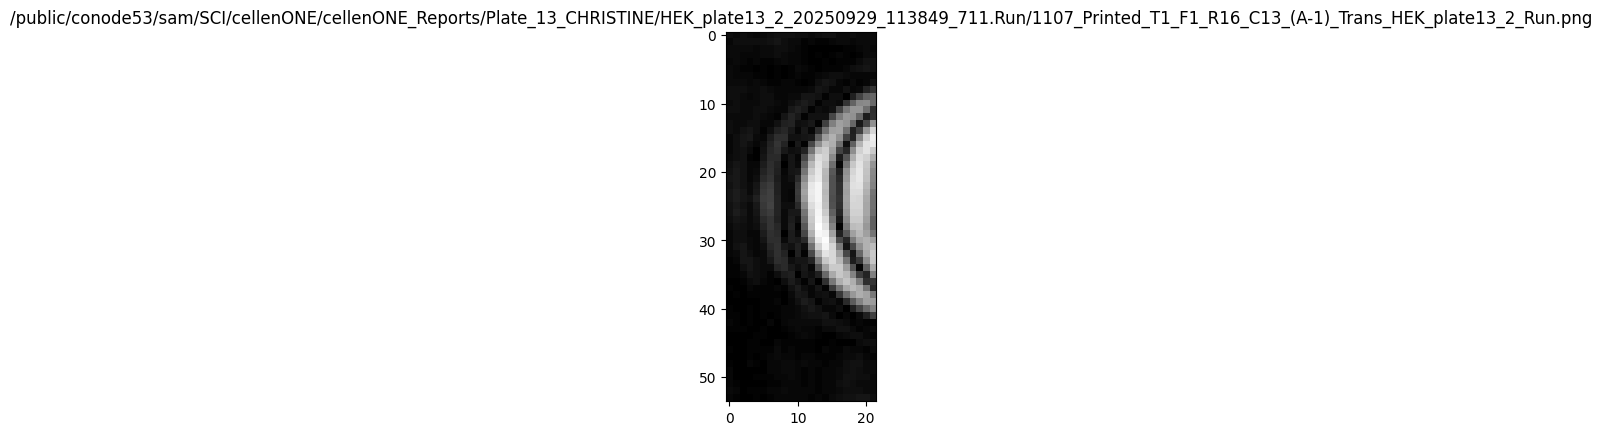

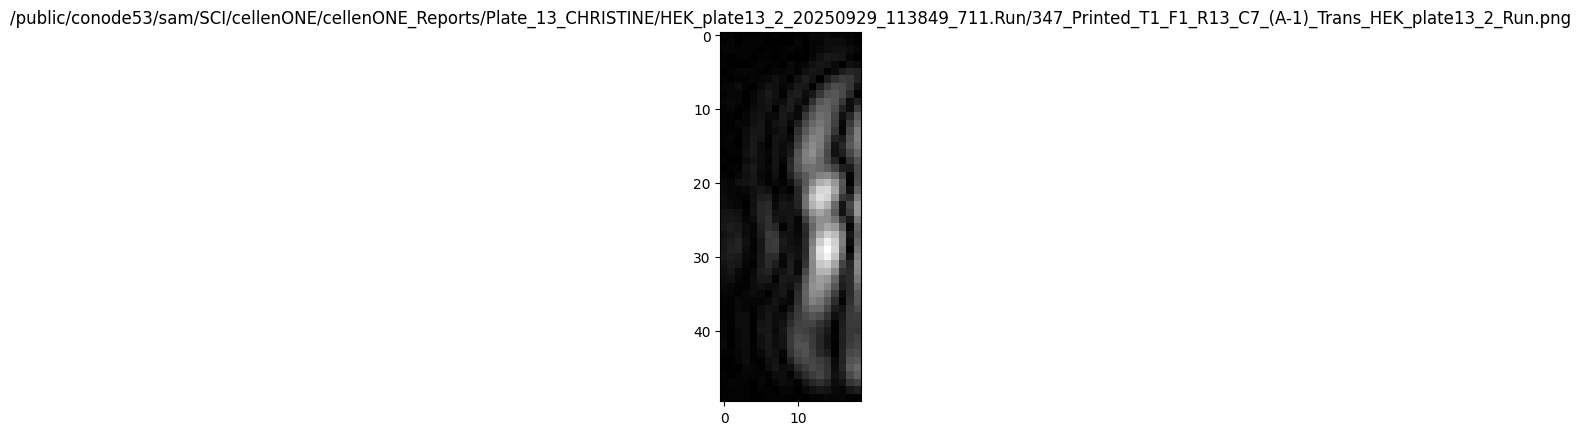

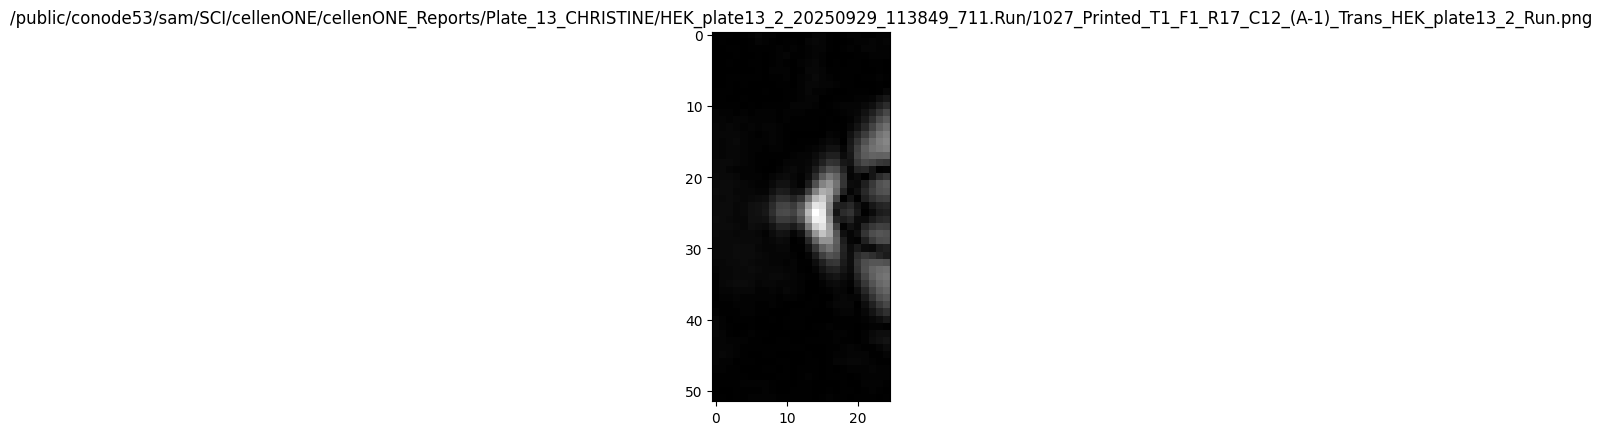

In [18]:
n = 0
for i, row in df[df['width']<15].iterrows():
    
    plt.imshow(row['cell_diff'], cmap='grey')
    plt.title(row['path'])
    plt.show()
    
    n += 1
    if n > 5:
        break


### III. Crude filtering of the data

In [19]:
width_q10_median = df.groupby('plate')['width'].quantile(.10).median()
width_q90_median = df.groupby('plate')['width'].quantile(.90).median()

height_q10_median = df.groupby('plate')['height'].quantile(.10).median()
height_q90_median = df.groupby('plate')['height'].quantile(.90).median()

print('Width:')
print('Min: {}'.format(width_q10_median))
print('Max: {}'.format(width_q90_median))

print('Height:')
print('Min: {}'.format(height_q10_median))
print('Max: {}'.format(height_q90_median))

Width:
Min: 31.150000000000002
Max: 44.5
Height:
Min: 25.150000000000002
Max: 40.0


In [39]:
df_selection = df.loc[
    (df['width'] >= width_q10_median) &
    (df['width'] <= width_q90_median) &
    (df['height'] >= height_q10_median) &
    (df['height'] <= height_q90_median)
].reset_index(drop=True)


print('Filtered out {} crops.'.format(df.shape[0] - df_selection.shape[0]))

Filtered out 1497 crops.


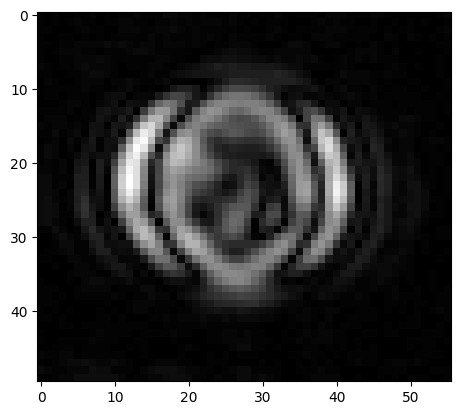

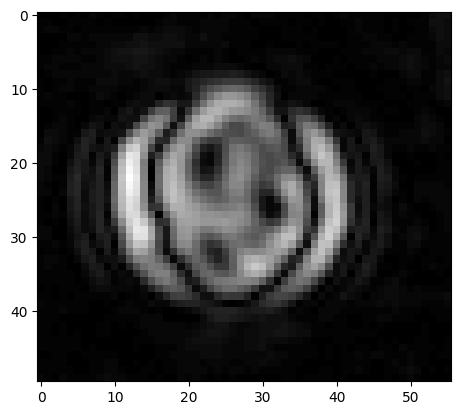

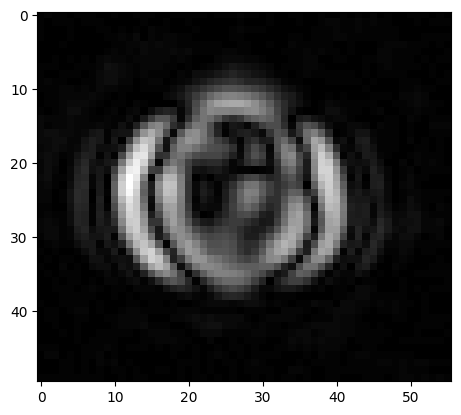

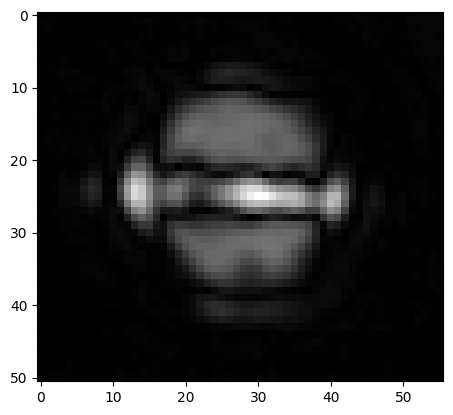

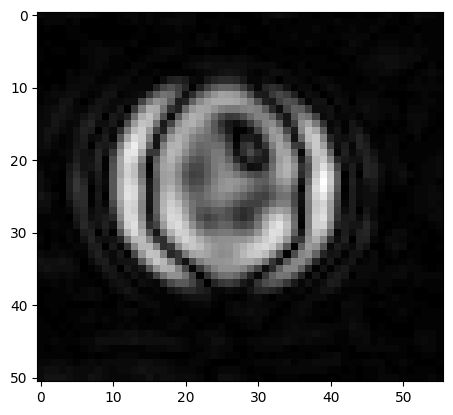

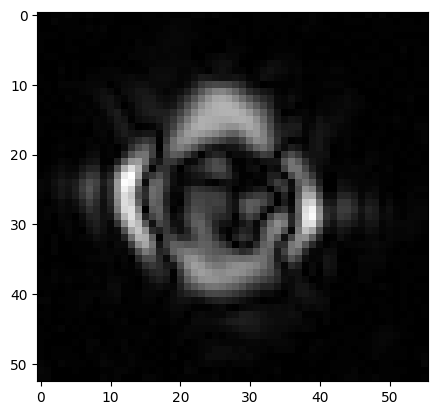

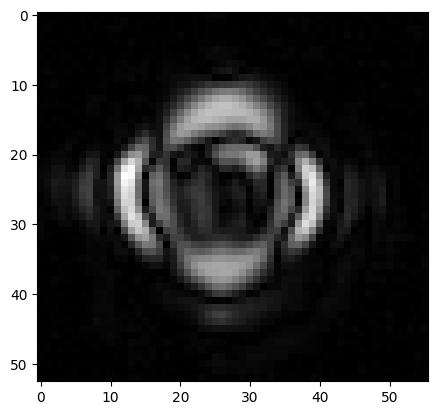

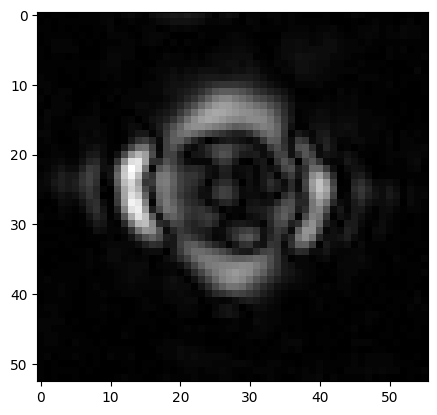

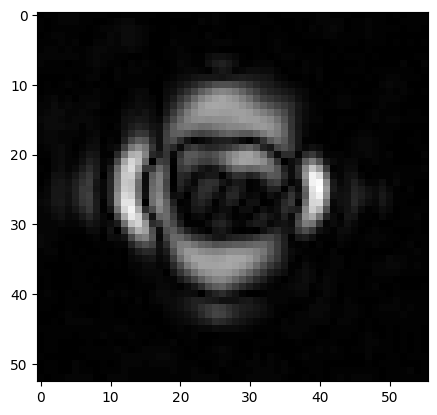

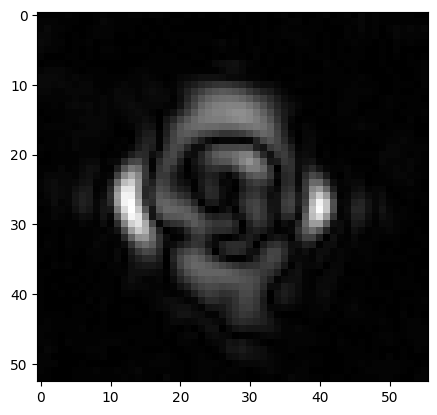

In [40]:
n = 0

for i, row in df_selection.sort_values(['width', 'height']).iterrows():
    n+=1
    if n > 10:
        break

    plt.imshow(row['cell_diff'], cmap='grey')
    plt.show()

for i, row in df_selection.sort_values(['width', 'height'], ascending=False).iterrows():
    n+=1
    if n > 10:
        break

    plt.imshow(row['cell_diff'], cmap='grey')
    plt.show()

In [41]:
df_selection.shape

(3642, 54)

<Axes: xlabel='height', ylabel='plate'>

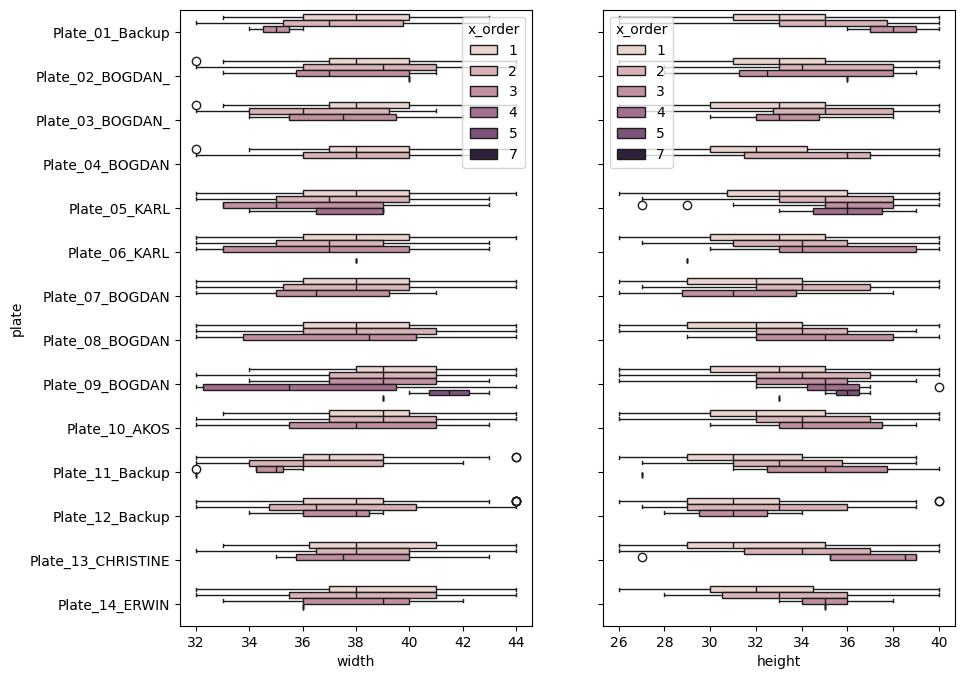

In [23]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,8))

sns.boxplot(
    df_selection.sort_values('plate'),
    x='width',
    y='plate',
    hue='x_order',
    ax=ax[0]
)

sns.boxplot(
    df_selection.sort_values('plate'),
    x='height',
    y='plate',
    hue='x_order',
    ax=ax[1]
)

In [24]:
df_selection[['width', 'height']].max()

width     44
height    40
dtype: int64

<Axes: xlabel='cell', ylabel='Count'>

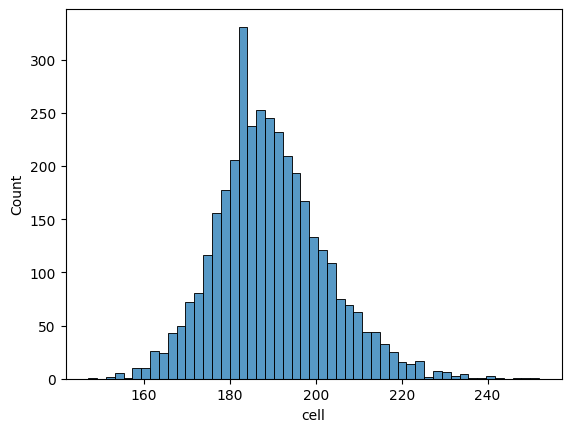

In [25]:
sns.histplot(df_selection['cell'].apply(lambda x: x.max()))

<Axes: xlabel='cell_diff', ylabel='Count'>

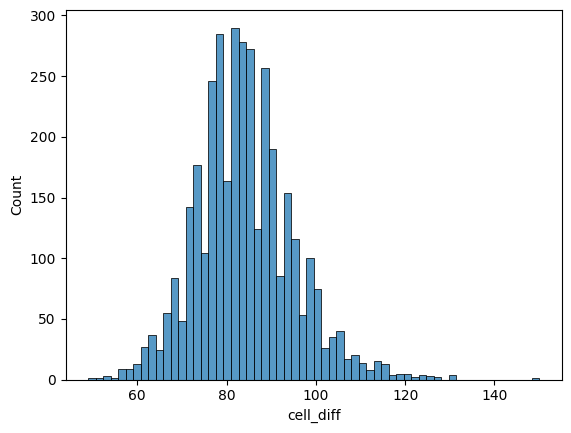

In [26]:
sns.histplot(df_selection['cell_diff'].apply(lambda x: x.max()))

### IV. Homogenizing the shape of the images

In [78]:
def infer_border_sizes(img_shape, target_w, target_h):
    """
    Compute symmetric (or near-symmetric) padding OR cropping
    needed to reach target size.

    If dimension is smaller → returns positive padding values.
    If dimension is larger  → returns negative padding values
      (indicating how much to crop symmetrically).

    Parameters
    ----------
    img_shape : tuple (height, width)
    target_w : int
    target_h : int

    Returns
    -------
    dict with keys: top, bottom, left, right
        Positive = pad that amount
        Negative = crop that amount
    """

    curr_h, curr_w = img_shape

    # --- WIDTH ---
    diff_w = target_w - curr_w   # positive → need pad, negative → need crop
    if diff_w >= 0:
        # pad
        left = diff_w // 2
        right = diff_w - left
    else:
        # crop (negative values indicate how much to remove)
        crop_total = -diff_w
        left = -(crop_total // 2)
        right = -(crop_total - (-left))

    # --- HEIGHT ---
    diff_h = target_h - curr_h
    if diff_h >= 0:
        top = diff_h // 2
        bottom = diff_h - top
    else:
        crop_total = -diff_h
        top = -(crop_total // 2)
        bottom = -(crop_total - (-top))

    return {
        "top": top,
        "bottom": bottom,
        "left": left,
        "right": right
    }


def pad_borders(img, target_w, target_h):
    b = infer_border_sizes(img.shape[:2], target_w, target_h)

    # --- Handle cropping first (negative values) ---
    if b["top"] < 0 or b['bottom'] < 0:
        img = img[-b["top"] : img.shape[0] + b["bottom"], :]
    if b["left"] < 0 or b['right'] < 0:
        img = img[:, -b["left"] : img.shape[1] + b["right"]]

    # --- Handle padding next (positive values) ---
    pad = {k: max(0, v) for k, v in b.items()}
    img = cv2.copyMakeBorder(
        img,
        pad["top"], pad["bottom"],
        pad["left"], pad["right"],
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    return img

In [79]:
df_selection['cell_diff_reshape'] = df_selection['cell_diff'].apply(
    lambda x: pad_borders(
        img=x,
        target_w=64,
        target_h=64
    )
)

# 4. Store in LanceDB

In [83]:
df_selection.columns

Index(['cell', 'cell_diff', 'mask', 'contours', 'plate', 'sample_type',
       'ImageFile', 'path', 'n', 'area', 'perimeter', 'circularity',
       'equivalent_diameter', 'aspect_ratio', 'elongation', 'solidity',
       'convexity', 'extent', 'x', 'y', 'width', 'height', 'zone', 'x_order',
       'DropNo', 'X', 'Y', 'Diameter', 'Elongation', 'Circularity',
       'Intensity', 'Teg', 'Plate', 'Well', 'Target', 'Field', 'XPos', 'YPos',
       'Date', 'Time', 'Background', 'EjBound', 'SedBound', 'DetDiaMinTrans',
       'DetDiaMaxTrans', 'IsoDiaMinTrans', 'IsoDiaMaxTrans', 'IsoIntMinTrans',
       'IsoIntMaxTrans', 'IsoDiaMinFlu', 'IsoDiaMaxFlu', 'IsoIntMinFlu',
       'IsoIntMaxFlu', 'PlatePosition', 'cell_diff_reshape'],
      dtype='object')

In [84]:
column_name_map = {
    'cell_diff_reshape': 'cell_diff_crop',
    'plate': 'plate_name',
    'sample_type': 'cell_type',
    'area': 'feature:area',
    'perimeter': 'feature:perimeter',
    'circularity': 'feature:circularity',
    'equivalent_diameter': 'feature:diameter',
    'aspect_ratio': 'feature:aspect_ratio',
    'elongation': 'feature:elongation',
    'solidity': 'feature:solidity',
    'convexity': 'feature:convexity',
    'extent': 'feature:extent',
    'x': 'segmentation:pixel_xpos',
    'y': 'segmentation:feature:pixel_ypos',
    'width': 'segmentation:pixel_width',
    'height': 'segmentation:pixel_height',
    'x_order': 'segmentation:cell_xindex',
    'X': 'CO:pixel_xpos',
    'Y': 'CO:pixel_ypos',
    'Diameter': 'CO:diameter',
    'Elongation': 'CO:elongation',
    'Circularity': 'CO:circularity',
    'Intensity': 'CO:intensity',
    'Well': 'CO:well',
    'XPos': 'CO:xpos',
    'YPos': 'CO:ypos',
    'Date': 'CO:date',
    'Time': 'CO:time',
    'EjBound': 'CO:+EjBound',
    'SedBound': 'CO:+SedBound',
    'DetDiaMinTrans': 'CO:+DetDiaMinTrans',
    'DetDiaMaxTrans': 'CO:+DetDiaMaxTrans',
    'IsoDiaMinTrans': 'CO:+IsoDiaMinTrans',
    'IsoDiaMaxTrans': 'CO:+IsoDiaMaxTrans',
    'IsoIntMinTrans': 'CO:+IsoIntMinTrans',
    'IsoIntMaxTrans': 'CO:+IsoIntMaxTrans',
    'IsoDiaMinFlu': 'CO:+IsoDiaMinFlu',
    'IsoDiaMaxFlu': 'CO:+IsoDiaMaxFlu',
    'IsoIntMinFlu': 'CO:+IsoIntMinFlu',
    'IsoIntMaxFlu': 'CO:+IsoIntMaxFlu'
}

df_selection = df_selection.rename(
    columns=column_name_map
)
df_selection = df_selection.loc[:, ['cell', 'mask', 'contours']+list(column_name_map.values())]

In [85]:
df_selection.columns

Index(['cell', 'mask', 'contours', 'cell_diff_crop', 'plate_name', 'cell_type',
       'feature:area', 'feature:perimeter', 'feature:circularity',
       'feature:diameter', 'feature:aspect_ratio', 'feature:elongation',
       'feature:solidity', 'feature:convexity', 'feature:extent',
       'segmentation:pixel_xpos', 'segmentation:feature:pixel_ypos',
       'segmentation:pixel_width', 'segmentation:pixel_height',
       'segmentation:cell_xindex', 'CO:pixel_xpos', 'CO:pixel_ypos',
       'CO:diameter', 'CO:elongation', 'CO:circularity', 'CO:intensity',
       'CO:well', 'CO:xpos', 'CO:ypos', 'CO:date', 'CO:time', 'CO:+EjBound',
       'CO:+SedBound', 'CO:+DetDiaMinTrans', 'CO:+DetDiaMaxTrans',
       'CO:+IsoDiaMinTrans', 'CO:+IsoDiaMaxTrans', 'CO:+IsoIntMinTrans',
       'CO:+IsoIntMaxTrans', 'CO:+IsoDiaMinFlu', 'CO:+IsoDiaMaxFlu',
       'CO:+IsoIntMinFlu', 'CO:+IsoIntMaxFlu'],
      dtype='object')

In [86]:
for col in ['cell', 'mask', 'contours', 'cell_diff_crop']:
    df_selection[col] = df_selection[col].apply(lambda x: x.astype(float).tolist())

In [87]:
df_selection.shape

(3642, 43)

In [88]:
lance.write_dataset(
    data_obj=df_selection,
    uri=os.path.join(
        root_data_storage,
        'cropped_cells_SCI_1'
    )
)

In [89]:
df_selection.groupby('plate_name').count()['cell']

plate_name
Plate_01_Backup       251
Plate_02_BOGDAN_      248
Plate_03_BOGDAN_      206
Plate_04_BOGDAN       215
Plate_05_KARL         287
Plate_06_KARL         289
Plate_07_BOGDAN       282
Plate_08_BOGDAN       305
Plate_09_BOGDAN       278
Plate_10_AKOS         303
Plate_11_Backup       222
Plate_12_Backup       227
Plate_13_CHRISTINE    269
Plate_14_ERWIN        260
Name: cell, dtype: int64